In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import download_nichenet_ligand_target_mx
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker

In [37]:
dataset = "squidpy_seqfish"
n_epochs = 3
lr = 0.01
batch_size = 64
n_hidden = 32
n_latent = 16
dropout_rate = 0.

In [38]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"

Using dataset squidpy_seqfish.


/Users/sebastian.birk/opt/anaconda3/envs/autotalkercpu/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [39]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [40]:
os.makedirs("mlruns", exist_ok=True)

In [41]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [42]:
# Mask that allows all genes
mask = np.ones((n_latent, len(adata.var)))

In [43]:
model = Autotalker(adata,
                   mask=mask,
                   n_hidden=n_hidden,
                   n_latent=n_latent,
                   dropout_rate=dropout_rate,
                   expr_decoder_recon_loss="nb")

GCN ENCODER - n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER - dropout_rate: 0.0


In [44]:
model.train(n_epochs=n_epochs,
            lr=lr,
            batch_size=batch_size,
            mlflow_experiment_id=experiment.experiment_id)

 |██████--------------| 33.3%  - train_loss: 38925145.6578593180 - valid_loss: 139224.7616604478 - valid_auroc_score: 0.8231827372 - valid_auprc_score: 0.7979191917 - valid_best_acc_score: 0.7666537106 - valid_best_f1_score: 0.7996521621Epoch end
 |█████████████-------| 66.7%  - train_loss: 128449.1647062266 - valid_loss: 123093.4359841418 - valid_auroc_score: 0.8862885335 - valid_auprc_score: 0.8557997165 - valid_best_acc_score: 0.8401637645 - valid_best_f1_score: 0.8498546633Epoch end
 |████████████████████| 100.0%  - train_loss: 125700.9708860019 - valid_loss: 125929.7028917911 - valid_auroc_score: 0.8844818209 - valid_auprc_score: 0.8559497564 - valid_best_acc_score: 0.8361940299 - valid_best_f1_score: 0.8488163689
Epoch end
Saving best state of the network...
Best state was in epoch 1
Model training finished...
Average test AUROC score: 0.9031080425931771
Average test AUPRC score: 0.8655908579103747
Average test best acc score: 0.8583701599326599
Average test best f1 score: 0.8704

In [15]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [30]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad",
                        use_cuda=True)

GCN ENCODER - n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER - dropout_rate: 0.0


In [31]:
latent = model.get_latent_representation()

In [32]:
latent_new_data = model.get_latent_representation(adata)

In [33]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

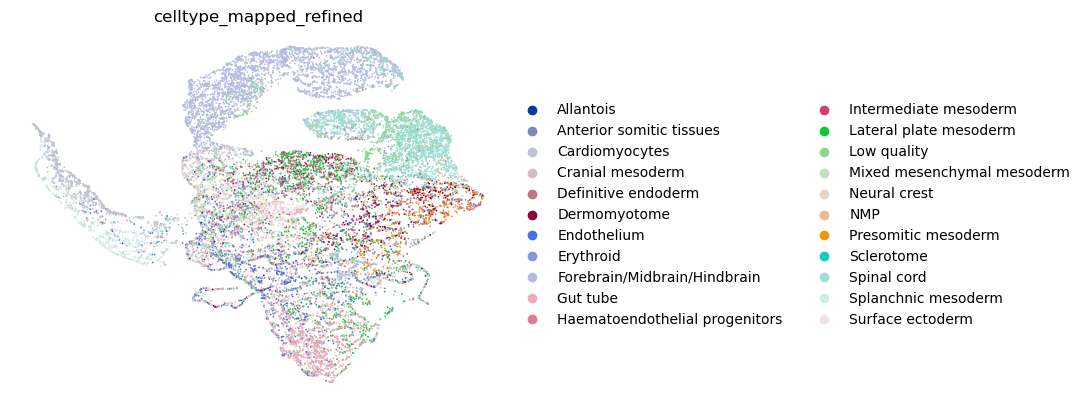

In [34]:
# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)

In [ ]:
download_nichenet_ligand_target_mx(save_path="data/ligand_target_matrix.csv")

In [ ]:
adata.var

In [ ]:
model = Autotalker(adata=adata,
                   mask=mask,
                   n_hidden=n_hidden)

In [ ]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [ ]:
model.train(n_epochs=n_epochs,
            lr=lr,
            batch_size=batch_size,
            mlflow_experiment_id=experiment.experiment_id)